Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 199MB/s]


In [ ]:
import cv2
import numpy as np
import torch
import torch.nn as nn
import torchvision.models as models
from torchvision import transforms
from PIL import Image
from sklearn.decomposition import PCA
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.preprocessing import StandardScaler

# Load a pretrained CNN (e.g., ResNet50)
cnn = models.resnet50(weights='IMAGENET1K_V1')
cnn = torch.nn.Sequential(*list(cnn.children())[:-1])  # Remove the final classification layer
cnn.eval()

# Define LSTM for temporal modeling of CNN features
class CNN_LSTM_Model(nn.Module):
    def _init_(self, cnn, lstm_hidden_size=512, num_lstm_layers=2):
        super(CNN_LSTM_Model, self)._init_()
        self.cnn = cnn
        self.lstm = nn.LSTM(input_size=2048,
                            hidden_size=lstm_hidden_size,
                            num_layers=num_lstm_layers,
                            batch_first=True)

    def forward(self, x):
        cnn_features = self.cnn(x)
        cnn_features = cnn_features.view(cnn_features.size(0), -1)
        lstm_out, (hn, cn) = self.lstm(cnn_features.unsqueeze(1))
        return hn[-1]

# Transformation for input frames
transform = transforms.Compose([
    transforms.Resize(224),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# Function to extract CNN + LSTM features from a single frame sequence
def extract_cnn_lstm_features(video_path, frame_skip=5):
    frames = video_to_frames(video_path, frame_skip)
    features = []

    print(f"Extracting features from {video_path}...")
    print(f"Total frames extracted: {len(frames)}")

    for frame in frames:
        frame = Image.fromarray(frame)
        frame = transform(frame).unsqueeze(0)

        with torch.no_grad():
            feature = cnn(frame).cpu().numpy()
            features.append(feature)

    print(f"Features extracted: {len(features)}")
    return np.array(features)

# Function to read video and extract frames
def video_to_frames(video_path, frame_skip=5):
    cap = cv2.VideoCapture(video_path)
    frames = []
    frame_count = 0
    while cap.isOpened():
        ret, frame = cap.read()
        if not ret:
            break
        if frame_count % frame_skip == 0:
            frames.append(frame)
        frame_count += 1
    cap.release()
    return frames

# Function to select videos and extract features
def select_and_extract_features():
    num_videos = int(input("Enter the number of videos to select: "))
    video_paths = []
    ground_truth_labels = []

    for i in range(num_videos):
        video_path = input(f"Enter path to video {i + 1}: ")
        video_paths.append(video_path)
        label = int(input(f"Enter ground truth label for video {i + 1} (0 or 1): "))
        ground_truth_labels.append(label)

    combined_features = []
    for video_path in video_paths:
        try:
            cnn_lstm_features = extract_cnn_lstm_features(video_path)
            combined_features.append(cnn_lstm_features)
        except Exception as e:
            print(f"Error processing video '{video_path}': {e}")

    if not combined_features:
        print("No features extracted. Exiting.")
        return

    # Flatten the features and combine them
    combined_features_flat = np.concatenate([features.flatten() for features in combined_features], axis=0)

    # --- Dimensionality Reduction and Feature Selection ---
    # 1. Apply PCA for initial dimensionality reduction
    pca = PCA(n_components=0.95)  # Retain 95% of variance (adjust as needed)
    reduced_features_pca = pca.fit_transform(combined_features_flat)

    # Convert ground truth labels to a numpy array
    your_target_labels = np.array(ground_truth_labels)

    # Adjust the shape of your target labels to match the number of samples
    num_samples_per_video = combined_features_flat.shape[0] // len(video_paths)
    your_target_labels_repeated = np.repeat(your_target_labels, num_samples_per_video)

    # Feature Selection
    selector = SelectKBest(f_classif, k=100)
    reduced_features = selector.fit_transform(reduced_features_pca, your_target_labels_repeated)

    # Normalize the reduced features to have mean=0 and std=1
    scaler = StandardScaler()  # Use StandardScaler instead of MinMaxScaler
    scaled_features = scaler.fit_transform(reduced_features)

    # Save scaled features to CSV with specified format
    output_filename = 'total3.csv'
    np.savetxt(output_filename, scaled_features, delimiter=',', fmt='%.4f')

    print("Features extracted and saved successfully.")

# **final video classification code**

In [ ]:
import cv2
import numpy as np
import torch
import torch.nn as nn
import torchvision.models as models
from torchvision import transforms
from PIL import Image
from sklearn.decomposition import PCA
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.preprocessing import StandardScaler

# Load a pretrained CNN (e.g., ResNet50)
cnn = models.resnet50(weights='IMAGENET1K_V1')
cnn = torch.nn.Sequential(*list(cnn.children())[:-1])  # Remove the final classification layer
cnn.eval()

# Define LSTM for temporal modeling of CNN features
class CNN_LSTM_Model(nn.Module):
    def __init__(self, cnn, lstm_hidden_size=512, num_lstm_layers=2):
        super(CNN_LSTM_Model, self).__init__()
        self.cnn = cnn
        self.lstm = nn.LSTM(input_size=2048,  # Output size of ResNet50
                            hidden_size=lstm_hidden_size,
                            num_layers=num_lstm_layers,
                            batch_first=True)

    def forward(self, x):
        # Extract CNN features
        cnn_features = self.cnn(x)  # Output shape: [batch_size, 2048, 1, 1]
        cnn_features = cnn_features.view(cnn_features.size(0), -1)  # Flatten to [batch_size, 2048]

        # Pass through LSTM
        lstm_out, (hn, cn) = self.lstm(cnn_features.unsqueeze(1))  # Add sequence dimension
        return hn[-1]  # Use the last hidden state as the final feature representation

# Transformation for input frames
transform = transforms.Compose([
    transforms.Resize(224),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# Function to extract features from a single frame
def extract_cnn_features(frame):
    frame = Image.fromarray(frame)
    frame = transform(frame).unsqueeze(0)
    with torch.no_grad():
        features = cnn(frame).squeeze()
    return features

# Function to read video and extract frames
def video_to_frames(video_path, frame_skip=5):
    cap = cv2.VideoCapture(video_path)
    frames = []
    frame_count = 0
    while cap.isOpened():
        ret, frame = cap.read()
        if not ret:
            break
        if frame_count % frame_skip == 0:
            frames.append(frame)
        frame_count += 1
    cap.release()
    return frames

# Function to select videos and extract features
def select_and_extract_features():
    num_videos = int(input("Enter the number of videos to select: "))
    video_paths = []
    ground_truth_labels = []

    for i in range(num_videos):
        video_path = input(f"Enter path to video {i + 1}: ")
        video_paths.append(video_path)
        label = int(input(f"Enter ground truth label for video {i + 1} (0 or 1): "))  # Assuming binary classification
        ground_truth_labels.append(label)

    # Extract features from selected videos
    combined_features = []
    for video_path in video_paths:
        try:
            frames = video_to_frames(video_path)
            cnn_features = [extract_cnn_features(frame) for frame in frames]
            features_np = torch.stack(cnn_features).cpu().numpy()
            combined_features.append(features_np)
        except Exception as e:
            print(f"Error processing video '{video_path}': {e}")

    return combined_features, ground_truth_labels, video_paths  # Return features, labels, and paths

if __name__ == "__main__":
    combined_features, ground_truth_labels, video_paths = select_and_extract_features()

    # Reshape each feature set
    # Reshape each feature set to 2D before concatenation
    combined_features_2d = [features.reshape(features.shape[0], -1) for features in combined_features]

    # Concatenate the reshaped features
    combined_features_flat = np.concatenate(combined_features_2d, axis=0)

    # --- Dimensionality Reduction and Feature Selection ---
    # 1. Apply PCA for initial dimensionality reduction
    pca = PCA(n_components=0.95)  # Retain 95% of variance (adjust as needed)
    reduced_features_pca = pca.fit_transform(combined_features_flat)

    # Convert ground truth labels to a numpy array
    your_target_labels = np.array(ground_truth_labels)

    # Adjust the shape of your target labels to match the number of samples
    num_samples_per_video = combined_features_flat.shape[0] // len(video_paths)

    # Calculate the remainder to adjust the repetition
    remainder = combined_features_flat.shape[0] % len(video_paths)

    # Repeat labels for each video, accounting for the remainder
    your_target_labels_repeated = []
    for i, label in enumerate(your_target_labels):
        repeat_count = num_samples_per_video
        if i < remainder:
            repeat_count += 1
        your_target_labels_repeated.extend([label] * repeat_count)  # Correctly append repeated labels

    your_target_labels_repeated = np.array(your_target_labels_repeated)  # Convert to numpy array

    # Feature Selection
    selector = SelectKBest(f_classif, k=100)
    reduced_features = selector.fit_transform(reduced_features_pca, your_target_labels_repeated)

    # Normalize the reduced features to have mean=0 and std=1
    scaler = StandardScaler()  # Use StandardScaler instead of MinMaxScaler
    scaled_features = scaler.fit_transform(reduced_features)

    # Save scaled features to CSV with specified format
    output_filename = 'total3.csv'
    np.savetxt(output_filename, scaled_features, delimiter=',', fmt='%.4f')

    print("Features extracted and saved successfully.")


Enter the number of videos to select: 2
Enter path to video 1: /content/VID-20241112-WA0041.mp4
Enter ground truth label for video 1 (0 or 1): 0
Enter path to video 2: /content/VID-20241113-WA0004.mp4
Enter ground truth label for video 2 (0 or 1): 0
Features extracted and saved successfully.


/usr/local/lib/python3.10/dist-packages/sklearn/feature_selection/_univariate_selection.py:776: UserWarning: k=100 is greater than n_features=74. All the features will be returned.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/feature_selection/_univariate_selection.py:108: RuntimeWarning: invalid value encountered in divide
  msb = ssbn / float(dfbn)


In [ ]:
import pandas as pd
df=pd.read_csv('total3.csv')
df

,-0.4688,-1.0243,-1.5939,0.1959,0.7007,-0.3734,2.0669,0.0769,1.1484,-2.6020,...,-1.8755,1.5189,2.3396,-1.6188,-2.6687,-1.5070,-2.0117,-0.9906,0.8707,-0.8577
0,-0.3772,-0.9909,-1.5151,0.3458,0.8017,-0.0676,2.5937,0.1280,1.1571,-2.3902,...,-1.6929,1.2700,2.4024,-2.0771,-2.9645,-1.0774,-1.6804,-0.4981,1.1725,-1.4584
1,-0.4494,-0.9042,-2.5392,0.2506,0.6197,-0.0302,1.3863,0.3023,1.8883,-3.1075,...,0.2278,0.2482,1.8897,-0.1494,-2.5021,-0.7118,-3.5783,-1.4262,1.6788,-2.1118
2,-0.2633,-0.9963,-2.1726,0.4215,0.2007,-0.1870,1.7303,1.0447,1.1734,-2.2338,...,0.7048,0.4016,3.3827,-2.1128,-2.2239,-0.4168,-2.6714,-0.3385,0.2924,-2.4647
3,-0.3610,-0.7678,-2.0108,0.1648,0.4139,-0.0430,1.5809,1.0219,1.7192,-2.9255,...,0.7282,1.0532,2.9068,-0.7108,-2.3787,-0.6626,-3.3546,-0.2810,-0.8955,-1.4270
4,-0.3813,-0.8675,-2.3528,-0.0216,0.3287,-0.6708,2.2834,1.2348,2.0106,-2.9205,...,-0.1551,-1.7973,2.8301,1.3326,-2.8469,0.4513,-1.8629,-1.5844,1.3294,-1.6676
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2742,1.2534,-0.3947,-0.6835,-1.2646,1.8620,0.8695,1.1419,0.9340,-1.1303,-0.5734,...,1.6448,-0.0581,-0.9427,-1.3119,0.7598,-0.4439,1.0121,1.1949,-0.1037,0.6962
2743,1.2735,-0.2121,-0.3009,-1.3243,1.9674,1.1664,0.4840,1.5009,-1.1218,-0.3886,...,1.1314,-0.0913,-1.5090,-0.9858,0.2724,0.1159,-0.2501,0.5675,-0.7250,0.4608
2744,1.2229,-0.1731,-0.2869,-1.4531,1.8346,1.1263,0.7712,1.1592,-1.3689,-0.5785,...,0.8611,0.3201,-1.2282,-0.9661,-0.2657,-0.4505,-0.3057,0.6285,-0.0139,-0.5018
2745,1.4327,-0.1051,-0.6715,-1.2007,2.1915,0.9044,1.1278,1.2153,-1.2679,-0.5768,...,0.7028,0.6290,-0.5168,-1.3988,1.1449,-0.8249,-0.0863,0.6854,-0.7159,0.0780


In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score

# Step 1: Load the dataset
data = pd.read_csv('total3.csv')

# Step 2: Preprocess the data
X = data.iloc[:, 1:]  # Features (all columns except the first)
y = data.iloc[:, 0]   # Labels (the first column)

# --- Check if labels are continuous ---
if pd.api.types.is_numeric_dtype(y):
    # If labels are continuous, proceed as is (no label encoding needed for regression)
    pass
else:
    # If labels are categorical, you should consider a classification approach instead
    raise ValueError("The target variable is categorical. Use a classifier instead.")

# Split the dataset into training and testing sets (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Step 3: Train a Random Forest regressor
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# Step 4: Evaluate the model
y_pred = model.predict(X_test)

# Print evaluation metrics
print("Mean Squared Error:", mean_squared_error(y_test, y_pred))
print("R^2 Score:", r2_score(y_test, y_pred))

Mean Squared Error: 0.11227767569766181
R^2 Score: 0.8872405900861423


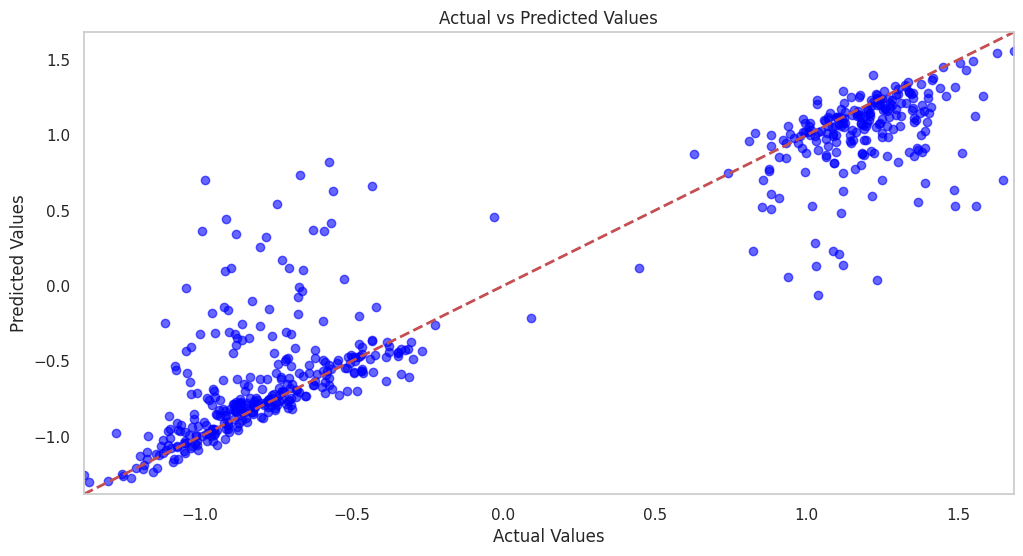

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming y_test and y_pred are already defined from your previous code

# Set the style of seaborn
sns.set(style="whitegrid")

# 1. Scatter Plot of Actual vs Predicted Values
plt.figure(figsize=(12, 6))
plt.scatter(y_test, y_pred, color='blue', alpha=0.6)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)  # Diagonal line
plt.title('Actual vs Predicted Values')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.xlim([y_test.min(), y_test.max()])
plt.ylim([y_test.min(), y_test.max()])
plt.grid()
plt.show()

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.preprocessing import LabelEncoder

# Step 1: Load the dataset
data = pd.read_csv('total3.csv')

# Step 2: Preprocess the data
X = data.iloc[:, 1:]  # Features (all columns except the first)
y = data.iloc[:, 0]   # Labels (the first column)

# Check if labels are continuous
if pd.api.types.is_numeric_dtype(y):
    # If labels are continuous, convert them to discrete classes using Label Encoding
    label_encoder = LabelEncoder()
    y = label_encoder.fit_transform(y)

# Split the dataset into training and testing sets (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Step 3: Train a Logistic Regression model
model = LogisticRegression(max_iter=1000, random_state=42)  # Increase max_iter if needed
model.fit(X_train, y_train)

# Step 4: Evaluate the model
y_pred = model.predict(X_test)

# Print evaluation metrics
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))

print("\nClassification Report:")
print(classification_report(y_test, y_pred))

print(f"Accuracy: {accuracy_score(y_test, y_pred):.2f}")

Confusion Matrix:
[[0 0 0 ... 0 0 0]
 [1 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]

Classification Report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         0
           3       0.00      0.00      0.00         1
           4       0.00      0.00      0.00         1
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
          12       0.00      0.00      0.00         0
          18       0.00      0.00      0.00         1
          26       0.00      0.00      0.00         1
          29       0.00      0.00      0.00         0
          33       0.00      0.00      0.00         1
          34       0.00      0.00      0.00         1
          38       0.00      0.00      0.00         1
          39       0.00      0.00      0.00         0
          44       0.00      0.00      0.00         0
          45       0.00    

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_

In [ ]:
from sklearn.datasets import load_iris
from sklearn.tree import DecisionTreeClassifier

# Load dataset (Iris dataset as an example)
data = load_iris()
X, y = data.data, data.target

# Initialize and train the Decision Tree Classifier
model = DecisionTreeClassifier()
model.fit(X, y)

# Define a new sample for classification
new_sample = [[5.1, 3.5, 1.4, 0.2]]  # Replace with your sample

# Predict the class of the new sample
prediction = model.predict(new_sample)
predicted_class = data.target_names[prediction[0]]

print(f"The predicted class for the new sample is: {predicted_class}")


The predicted class for the new sample is: setosa


In [ ]:
from sklearn.decomposition import PCA
import numpy as np

# Example dataset: 5 samples with 4 features each
data = np.array([[2.5, 2.4, 3.6, 4.5],
                 [0.5, 0.7, 1.2, 1.1],
                 [2.2, 2.9, 3.1, 4.0],
                 [1.9, 2.2, 3.8, 3.5],
                 [3.1, 3.0, 4.0, 4.2]])

# Initialize PCA to reduce to 2 dimensions
pca = PCA(n_components=2)

# Fit and transform the data
reduced_data = pca.fit_transform(data)

# Print the reduced data
print("Reduced Data:")
print(reduced_data)

# Explained variance ratio
print("\nExplained Variance Ratio:")
print(pca.explained_variance_ratio_)


Reduced Data:
[[ 1.14611995 -0.03416981]
 [-3.75023281 -0.05035582]
 [ 0.65676833 -0.50596849]
 [ 0.27969658  0.57791333]
 [ 1.66764795  0.01258079]]

Explained Variance Ratio:
[0.9424708  0.02998029]
